In [17]:
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
import matplotlib.pyplot as plt
import pytesseract
import imutils
import cv2
import re
import requests
import numpy as np

In [18]:
def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)
 
    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []
 
            for i in range(len(img)):
                titles.append(title)
 
        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
 
            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])
 
        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 
        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

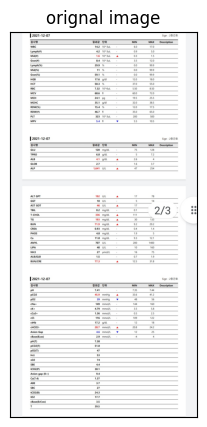

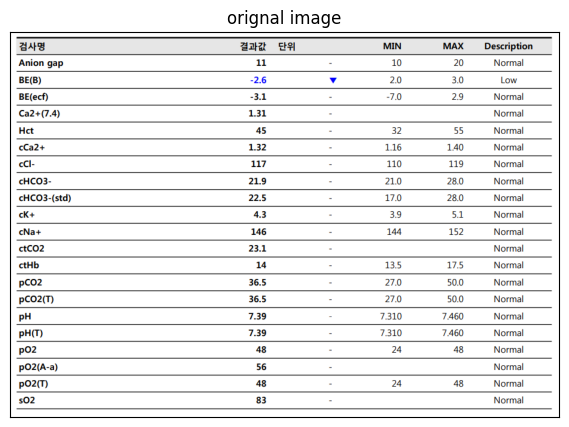

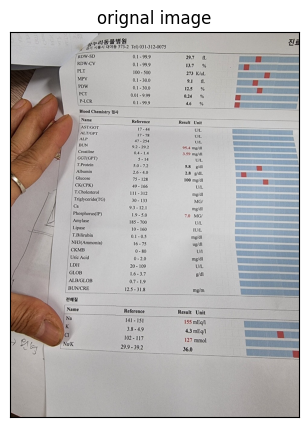

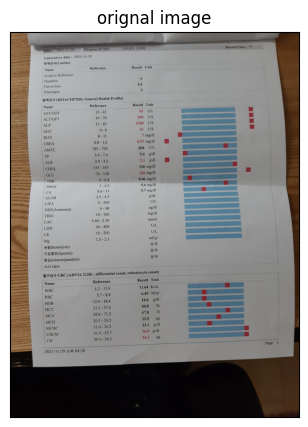

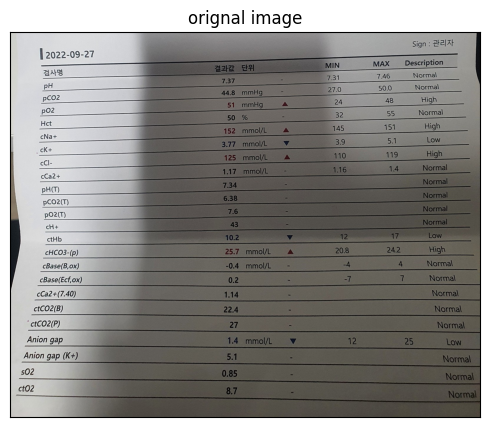

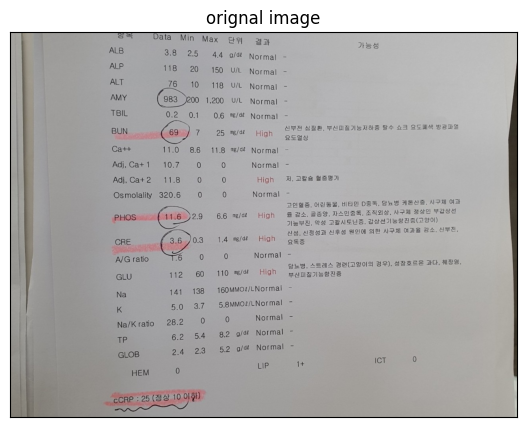

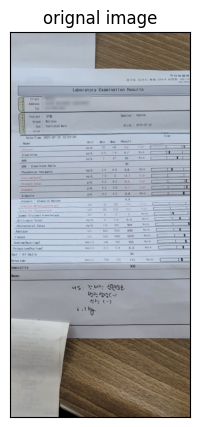

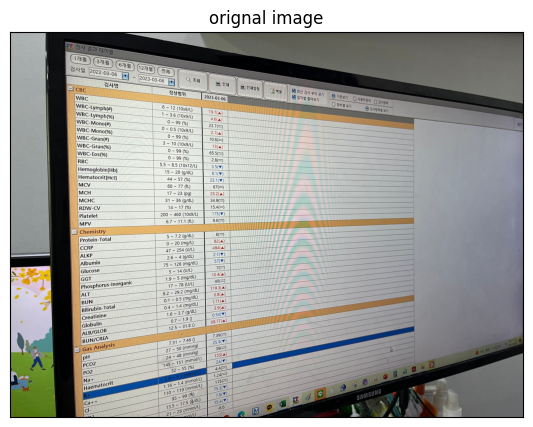

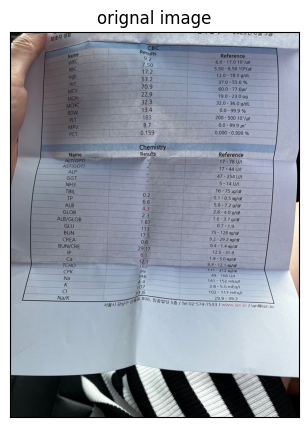

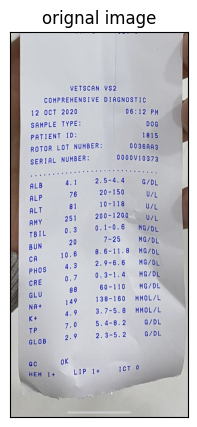

In [24]:
# 파일 경로 리스트
image_path_list = ['computer2.jpg', 'computer2.png', 'inside_folded_hand.jpg', 'inside_folded.jpg', 'inside_shadow.jpg', 'inside.jpg', 'low_resolution_folded.jpeg', 'moniter.jpg', 'outside_folded_hand.jpg', 'receipt_like.png']
org_image = []

for image_path in image_path_list:
    # OpenCV를 사용하여 이미지 파일 로드
    a = cv2.imread('../sample/' + image_path)
    
    # 이미지 리스트에 추가
    org_image.append(a)
    
    # 이미지 표시
    plt_imshow("orignal image", a)

In [25]:
def make_scan_image(image, width, ksize=(5,5), min_threshold=75, max_threshold=200):
  image_list_title = []
  image_list = []
 
  org_image = image.copy()
  image = imutils.resize(image, width=width)
  ratio = org_image.shape[1] / float(image.shape[1])
 
  # 이미지를 grayscale로 변환하고 blur를 적용
  # 모서리를 찾기위한 이미지 연산
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, ksize, 0)
  edged = cv2.Canny(blurred, min_threshold, max_threshold)
 
  image_list_title = ['gray', 'blurred', 'edged']
  image_list = [gray, blurred, edged]
 
  # contours를 찾아 크기순으로 정렬
  cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
 
  findCnt = None
 
  # 정렬된 contours를 반복문으로 수행하며 4개의 꼭지점을 갖는 도형을 검출
  for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
 
    # contours가 크기순으로 정렬되어 있기때문에 제일 첫번째 사각형을 영역으로 판단하고 break
    if len(approx) == 4:
      findCnt = approx
      break
 
  # 만약 추출한 윤곽이 없을 경우 오류
  if findCnt is None:
    raise Exception(("Could not find outline."))
 
  output = image.copy()
  cv2.drawContours(output, [findCnt], -1, (0, 255, 0), 2)
  
  image_list_title.append("Outline")
  image_list.append(output)
 
  # 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
  transform_image = four_point_transform(org_image, findCnt.reshape(4, 2) * ratio)
 
  plt_imshow(image_list_title, image_list)
  plt_imshow("Transform", transform_image)
 
  return transform_image

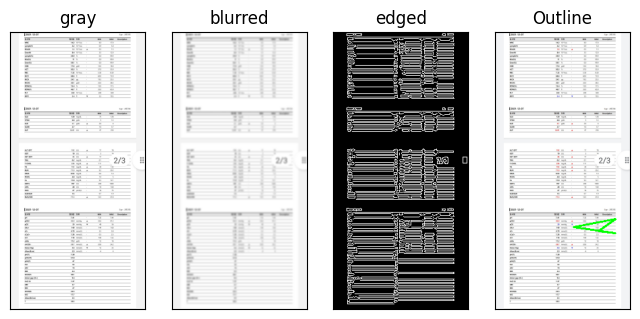

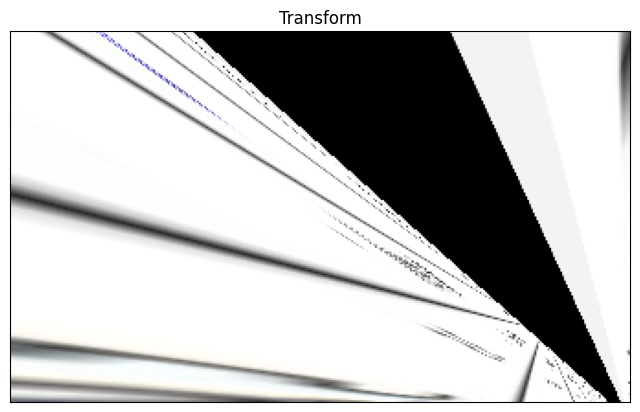

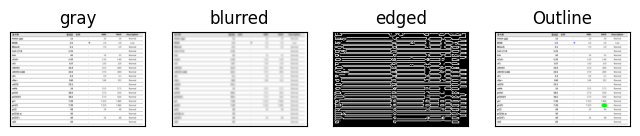

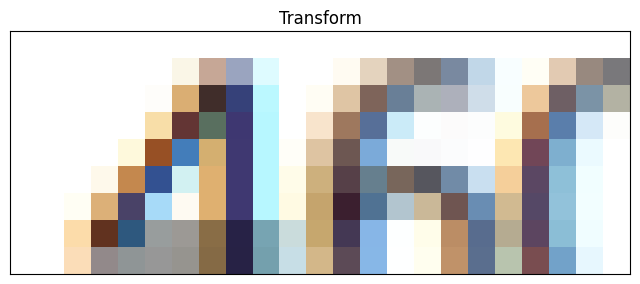

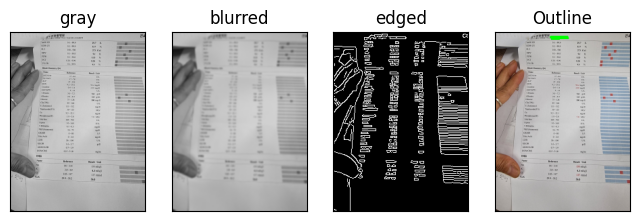

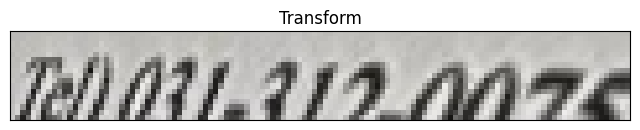

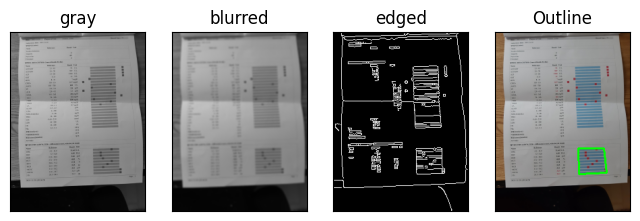

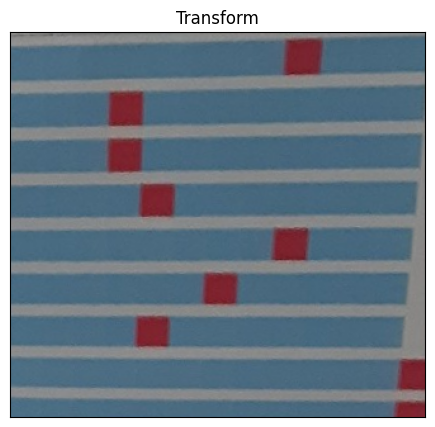

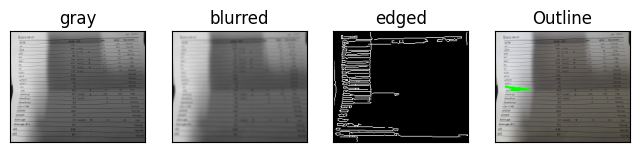

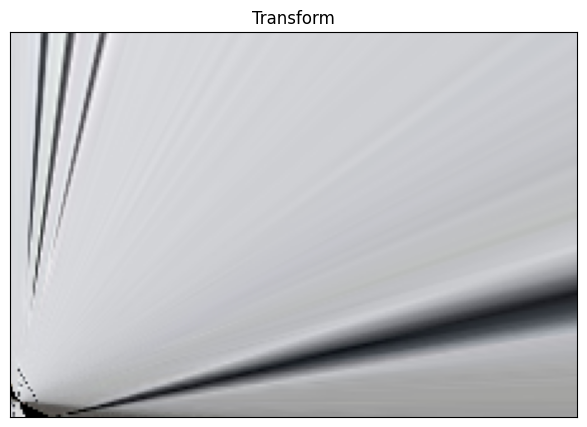

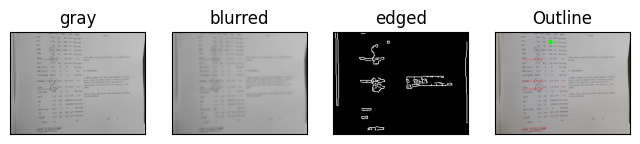

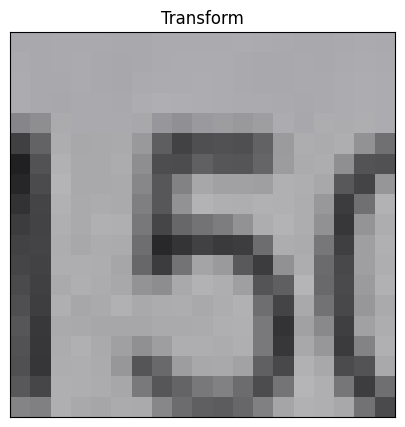

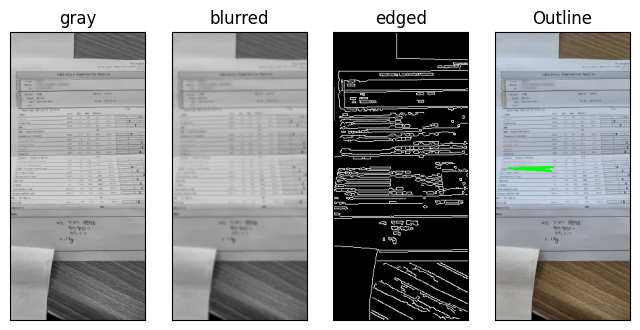

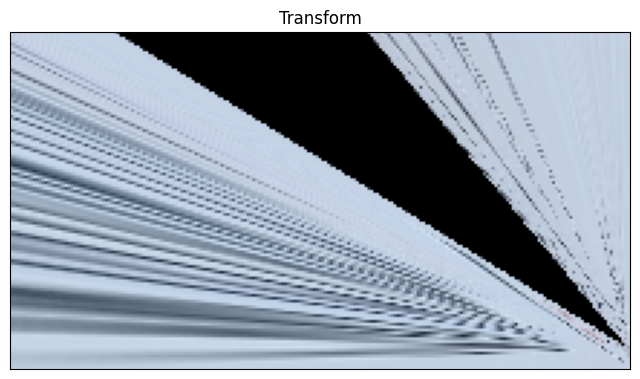

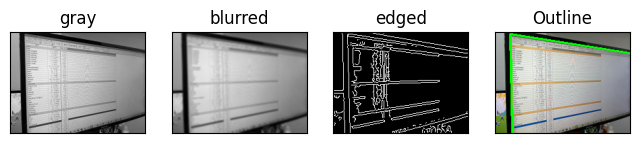

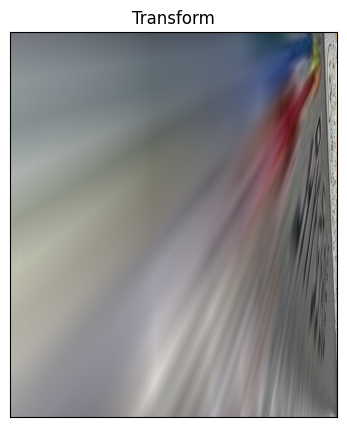

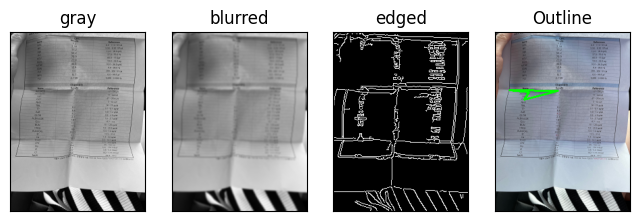

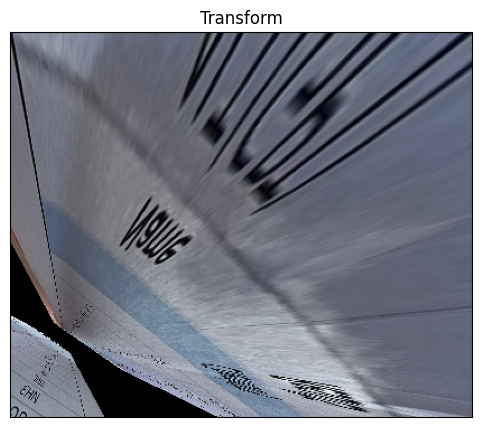

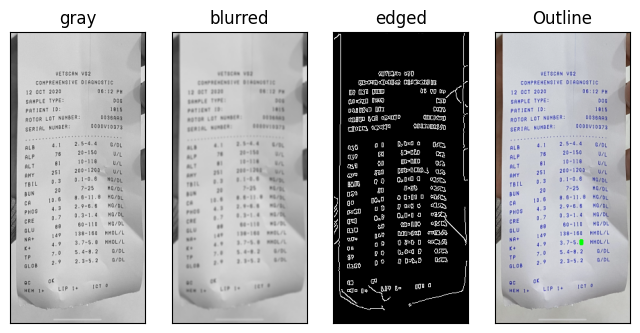

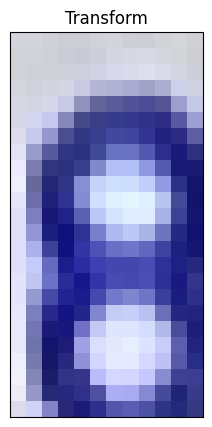

In [30]:
receipt = []

for i in org_image:
    # 이미지 리스트에 추가
    receipt.append(make_scan_image(i, width=200, ksize=(5, 5), min_threshold=20, max_threshold=100))

In [31]:
options = "--psm 4"

for i in receipt:
    # OpenCV 이미지를 RGB 형식으로 변환 후 OCR 수행
    text = pytesseract.image_to_string(cv2.cvtColor(i, cv2.COLOR_BGR2RGB), config=options)

    # OCR 결과 출력
    print("[INFO] OCR 결과:")
    print("==================")
    print(text)
    print("\n")

[INFO] OCR 결과:



[INFO] OCR 결과:



[INFO] OCR 결과:
RANA UI NAG



[INFO] OCR 결과:



[INFO] OCR 결과:
H
w=



[INFO] OCR 결과:



[INFO] OCR 결과:



[INFO] OCR 결과:



[INFO] OCR 결과:



[INFO] OCR 결과:





In [34]:
gray = cv2.cvtColor(receipt, cv2.COLOR_BGR2GRAY)
(H, W) = gray.shape
 
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 20))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 21))
 
gray = cv2.GaussianBlur(gray, (11, 11), 0)
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)
 
grad = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
grad = np.absolute(grad)
(minVal, maxVal) = (np.min(grad), np.max(grad))
grad = (grad - minVal) / (maxVal - minVal)
grad = (grad * 255).astype("uint8")
 
grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(grad, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
 
close_thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
close_thresh = cv2.erode(close_thresh, None, iterations=2)
 
plt_imshow(["Original", "Blackhat", "Gradient", "Rect Close", "Square Close"], [receipt, blackhat, grad, thresh, close_thresh], figsize=(16, 10))

error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [ ]:
plt_imshow(["Square Close"], [close_thresh], figsize=(16, 10))

In [ ]:
cnts = cv2.findContours(close_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="top-to-bottom")[0]
 
roi_list = []
roi_title_list = []
 
margin = 20
receipt_grouping = receipt.copy()
 
for c in cnts:
  (x, y, w, h) = cv2.boundingRect(c)
  ar = w // float(h)
 
  if ar > 3.0 and ar < 6.5 and (W/2) < x:
    color = (0, 255, 0)
    roi = receipt[y - margin:y + h + margin, x - margin:x + w + margin]
    roi_list.append(roi)
    roi_title_list.append("Roi_{}".format(len(roi_list)))
  else:
    color = (0, 0, 255)
 
  cv2.rectangle(receipt_grouping, (x - margin, y - margin), (x + w + margin, y + h + margin), color, 2)
  cv2.putText(receipt_grouping, "".join(str(ar)), (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.65, color, 2)
  
  plt_imshow(["Grouping Image"], [receipt_grouping], figsize=(16, 10))

In [ ]:
plt_imshow(roi_title_list, roi_list, figsize=(16, 10))
 
for roi in roi_list:
  gray_roi= cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
  threshold_roi = cv2.threshold(gray_roi, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
  roi_text = pytesseract.image_to_string(threshold_roi)
  print(roi_text)

In [ ]:
def mergeResize(img, row=300, col=200):
    IMG_COL = col #66
 
    # row값에 따른 col값 변경
    IMG_COL = int((row * IMG_COL)/row)
 
    IMG_ROW = row
    border_v = 0
    border_h = 0
 
    if (IMG_COL / IMG_ROW) >= (img.shape[0] / img.shape[1]):
        border_v = int((((IMG_COL / IMG_ROW) * img.shape[1]) - img.shape[0]) / 2)
    else:
        border_h = int((((IMG_ROW / IMG_COL) * img.shape[0]) - img.shape[1]) / 2)
    img = cv2.copyMakeBorder(img, top=border_v, bottom=border_v, left=0, right=border_h + border_h, borderType=cv2.BORDER_CONSTANT, value=(255, 255, 255))
    img = cv2.resize(img, (IMG_ROW, IMG_COL))
    return img

In [ ]:
for idx, roi in enumerate(roi_list):
  if idx == 0:
    mergeImg = mergeResize(roi)
  else:
    cropImg = mergeResize(roi)
    mergeImg = np.concatenate((mergeImg, cropImg), axis=0)
    
threshold_mergeImg = cv2.threshold(mergeImg, 150, 255, cv2.THRESH_BINARY)[1]
plt_imshow(["Merge Image"], [threshold_mergeImg])
merge_Img_text = pytesseract.image_to_string(threshold_mergeImg)
print(merge_Img_text)

In [16]:
import cv2
import pytesseract

# 이미지 파일 경로
image_path = "..\sample\computer2.jpg"

# 이미지 불러오기
image = cv2.imread(image_path)

# 이미지 전처리 (옵션)
# 필요한 경우 이미지에 전처리를 수행하여 OCR의 정확도를 높일 수 있습니다.
# 예를 들어, 이미지 이진화, 잡음 제거 등을 수행할 수 있습니다.
# 이는 이미지 특성에 따라 다를 수 있으므로 상황에 맞게 적용해 주세요.

# pytesseract 설정
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
pytesseract.pytesseract.tesseract_version = '2'

# OCR 수행
text = pytesseract.image_to_string(image, lang='eng+kor')

# 인식된 텍스트 출력
print(text)

| 2021-12-07 Sign : 28218

검 사 명 결 과 값 단위 MIN MAX _ Description
‘WBC 14.2 10*3uL 님 60 17.0
Lymph(#) 42 10*3uL : 09 5.0
Mid(#) 1.6 1043uL a 03 15
Gran(#) 8.4 10%3uL - 35 120
Lymph(%) 29.9 % - 0.0 999
Mid(%) 11 % 닐 00 99.9
Gran(%) 59.1 % = 0.0 99.9
HGB 17.6 g/dl 님 12.0 18.0
HCT 50.3 % - 370 55.0
RBC 7.32 10*6uL 님 5.50 8.50
MCV 68.6 fi - 60.0 720
MCH 24.1 pg - 19.5 255
MCHC 35.1 g/dl : 32.0 38.5
RDW(%) 15.4 % a 12.0 175
RDW(#) 46.7 fl “ 35.0 65.0
PLT 323 1043uL : 200 500
MPV 5.4 fl v SS 105
| 2021-12-07 Sign : 2 층 간호
검 사 명 결 과 값 단위 MIN

GLU 120 mg/dl = 75 128
TPRO 6.8 g/dl 님 5 72
ALB 4.1 g/dl a 26 4
GLOB 27 : 16 a7
ALP 1,641 U/L a 47 254
ALT GPT 192 U/L a 17 78
GGT 10 U/L = 5 14
AST GOT 46 U/L a 7

TBIL 0.2 mg/dl 01 2 / 3 y
T-CHOL 336 mg/dl a 111 -
76 193 mg/dl a 30 133
BUN 71.9 mg/di a 9.2 29.2
CREA 0.93 mg/di = 04 14
PHOS 48 mg/dl 뽀 19 5
ca 11.8 mg/d - a3 121
AMYL 707 U/L = 200 1400
LIPA 40 U/L = 10 160
NH3 27 «mol/L : 16 75
ALB/GLB 15 = 07 19
BUN/CRE 77.3 a 125 318
| 2021-12-07 Sign : 